# EDA and Preprocessing

This notebook covers the Exploratory Data Analysis (EDA) and preprocessing steps for the AAI-530 final project.

Goals:
- Load and validate the AI4I 2020 Predictive Maintenance dataset
- Perform core EDA (types, missing values, duplicates, target distribution)
- Explore feature distributions, feature-to-target relationships, and correlations
- Document the project-specific assumption of using `Tool wear [min]` as a proxy for time progression
- Prepare a leakage-aware modeling dataset (drop IDs, remove failure-mode flags, encode categorical features)
- Export a prepared dataset for downstream modeling notebooks


### 1. Imports & setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

### 2. Load dataset and quick validation

In [2]:
# Path to dataset
DATA_PATH = "../data/ai4i_2020_predictive_maintenance.csv"

# Load CSV
df = pd.read_csv(DATA_PATH)

# Basic check
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### 3. Feature distributions and outliers

This section checks basic feature distributions to highlight skewness and potential outliers before modeling.

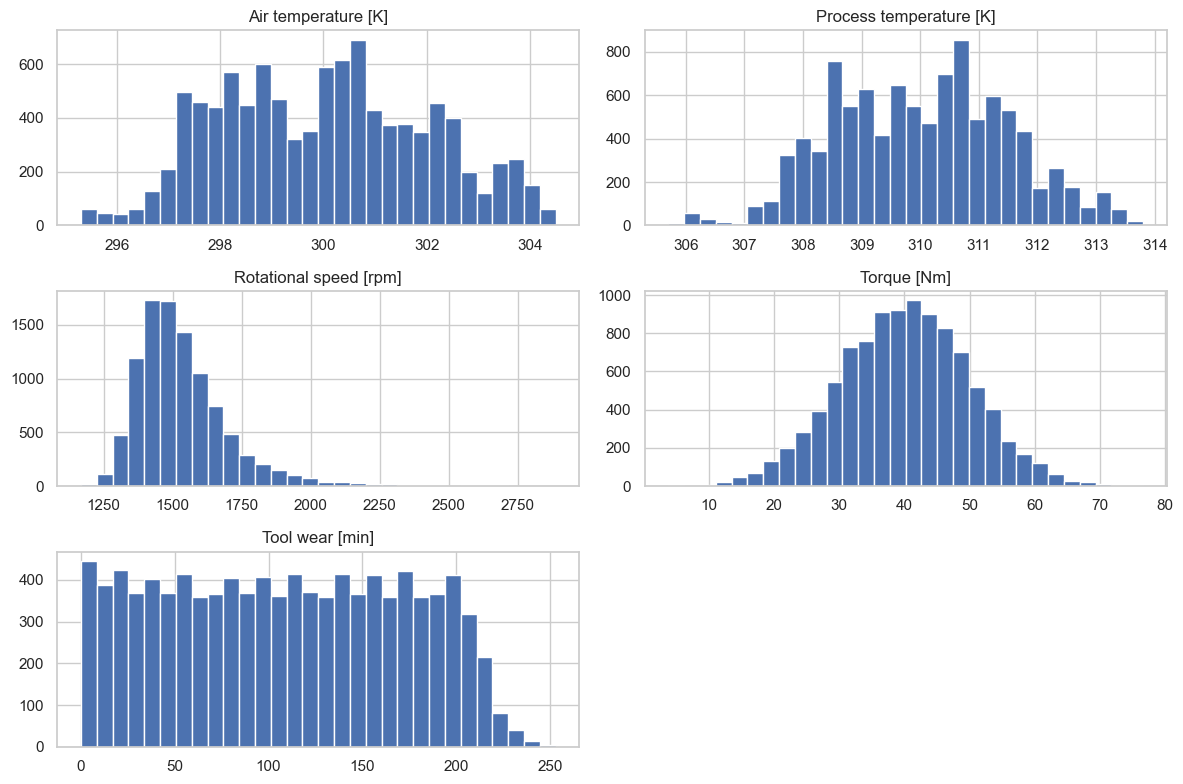

In [3]:
import matplotlib.pyplot as plt

numeric_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

### 4. Dataset structure and summary statistics

In [4]:
print("Dataset shape:", df.shape)
print("\nColumn info:")
df.info()

Dataset shape: (10000, 14)

Column info:
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  str    
 2   Type                     10000 non-null  str    
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64 

#### Summary statistics

In [5]:
df.describe(include="all")

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
unique,NaN,10000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M14860,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,NaN,NaN,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,NaN,NaN,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,NaN,NaN,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,NaN,NaN,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,NaN,NaN,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,NaN,NaN,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


### 5. Data quality checks (missing, uniqueness, duplicates)

In [6]:
missing= df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

#### Check uniqueness and duplicates

In [7]:
df.nunique().sort_values()
df.duplicated().sum()

print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


### 6. Target variable analysis

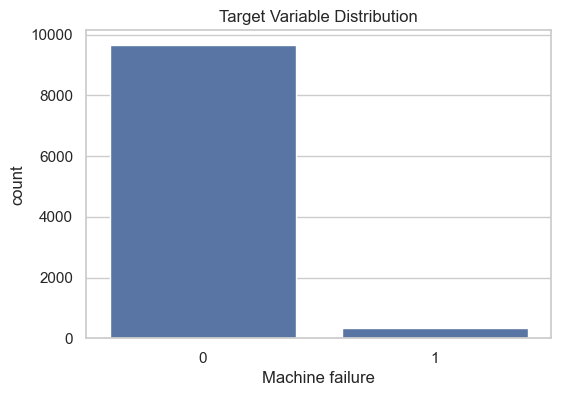

In [8]:
# Assuming 'Machine failure' is the target
target_col = "Machine failure"

df[target_col].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title("Target Variable Distribution")
plt.show()

The target variable is highly imbalanced, with failures representing a small fraction of observations, which motivates the use of stratified sampling and appropriate evaluation metrics in downstream models.

### 7. Identifying the time-series variable

In [9]:
df['Tool wear [min]'].describe()

count    10000.000000
mean       107.951000
std         63.654147
min          0.000000
25%         53.000000
50%        108.000000
75%        162.000000
max        253.000000
Name: Tool wear [min], dtype: float64

### 8. Time proxy exploration using tool wear

**Assumption: using tool wear as a proxy for time**

The AI4I dataset is not a single-machine chronological log. For this project, we treat `Tool wear [min]` as a proxy for progression over time-under-use. When we aggregate and visualize trends by tool wear, results reflect population-level patterns rather than an individual machine trajectory.

In [10]:
df = df.sort_values('Tool wear [min]').reset_index(drop=True)

### Failure vs key features

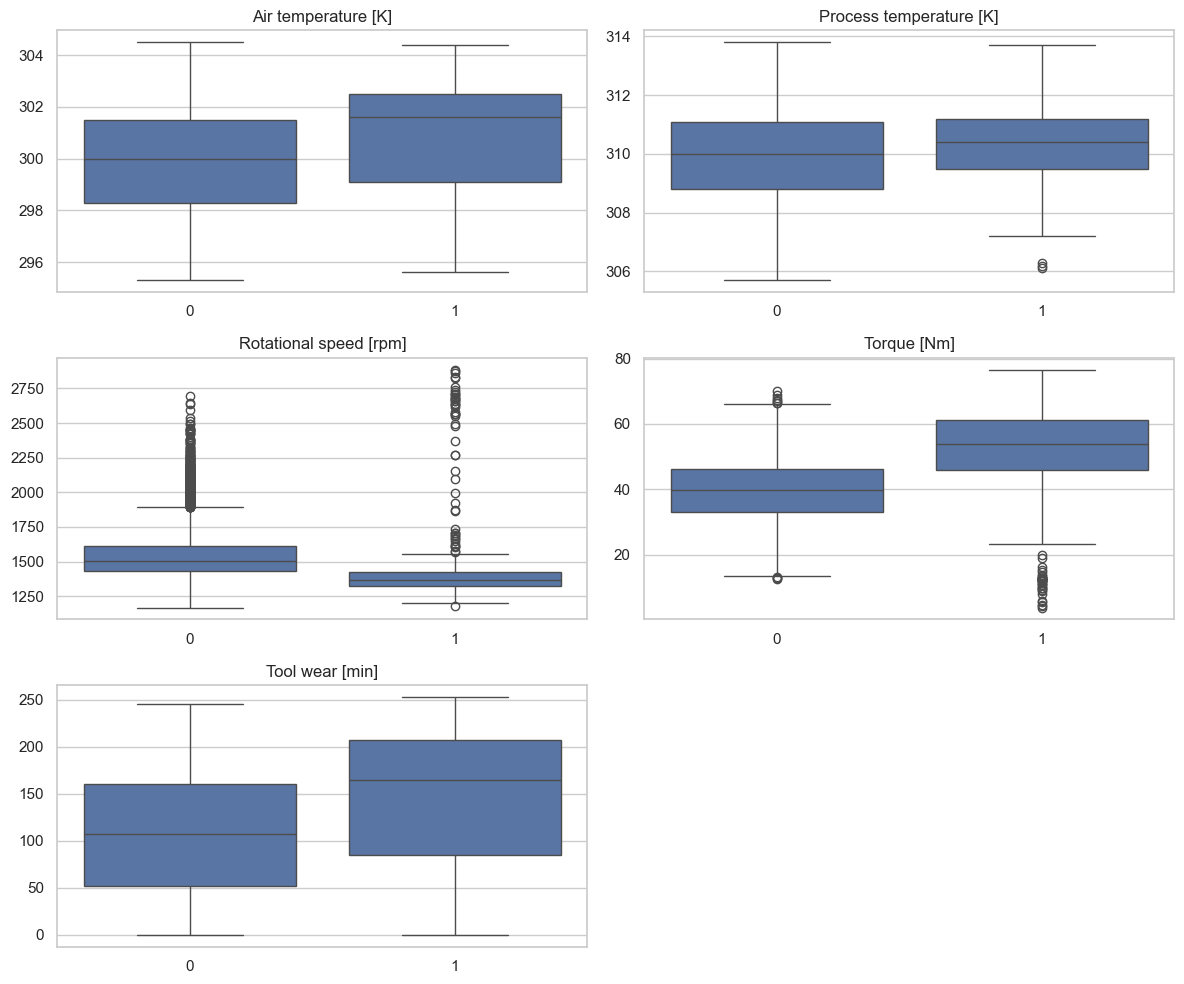

In [11]:
key_features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, feature in zip(axes, key_features):
    sns.boxplot(x=target_col, y=feature, data=df, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel("")
    ax.set_ylabel("")

for ax in axes[len(key_features):]:
    ax.remove()

plt.tight_layout()
plt.show()

### 9. Correlation analysis

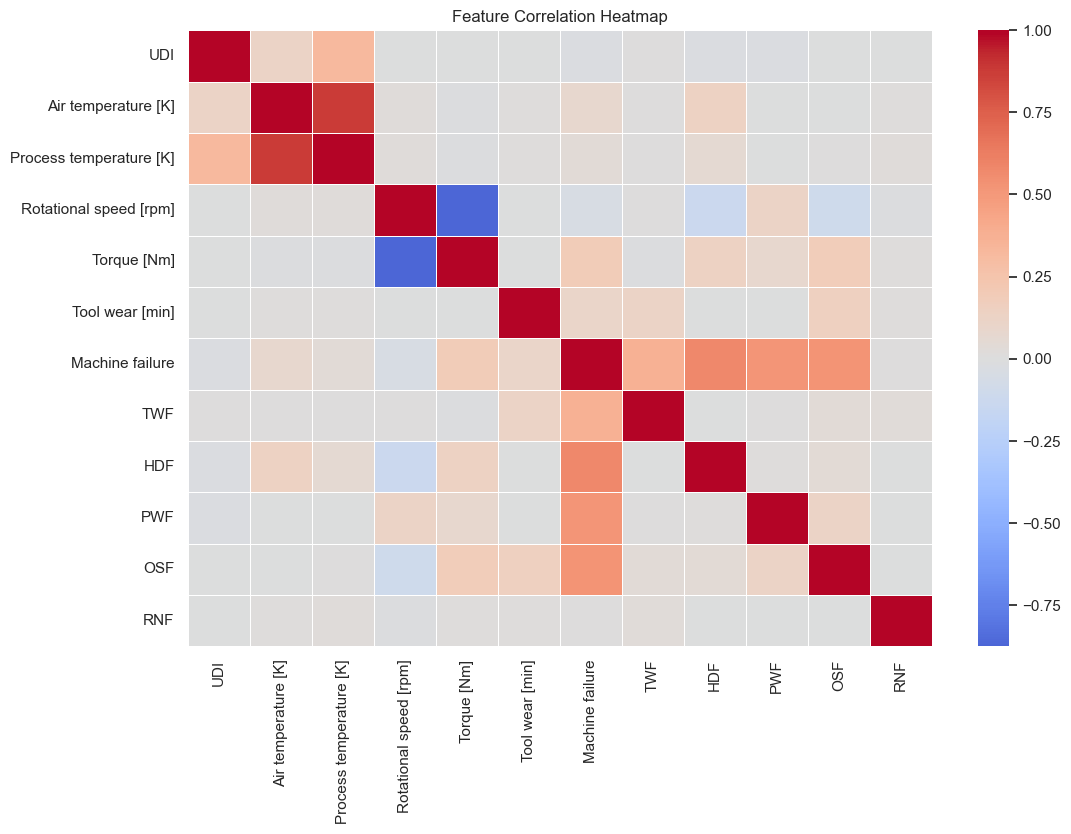

In [12]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12, 8))
corr = df[numerical_cols].corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap")
plt.show()

### 10. Time-series behavior using Tool wear

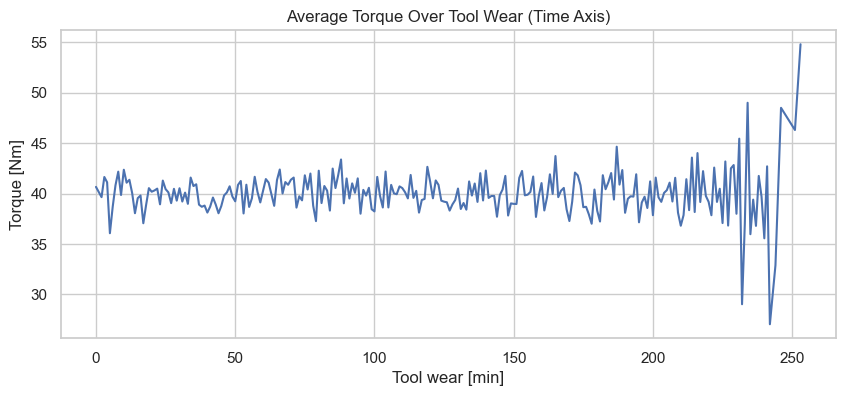

In [13]:
df_tw = df.groupby('Tool wear [min]', as_index=False).mean(numeric_only=True)

plt.figure(figsize=(10,4))
plt.plot(df_tw['Tool wear [min]'], df_tw['Torque [Nm]'])
plt.title("Average Torque Over Tool Wear (Time Axis)")
plt.xlabel("Tool wear [min]")
plt.ylabel("Torque [Nm]")
plt.show()

### 11. Moving average smoothing to reduce noise

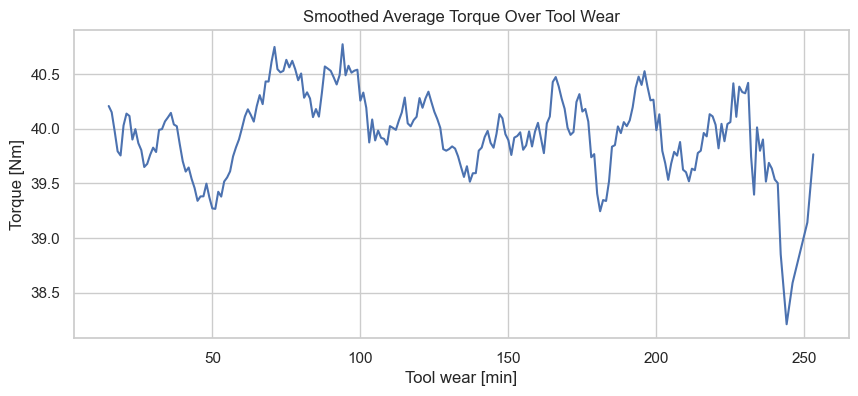

In [14]:
df_tw['Torque_ma'] = df_tw['Torque [Nm]'].rolling(window=15).mean()

plt.figure(figsize=(10,4))
plt.plot(df_tw['Tool wear [min]'], df_tw['Torque_ma'])
plt.title("Smoothed Average Torque Over Tool Wear")
plt.xlabel("Tool wear [min]")
plt.ylabel("Torque [Nm]")
plt.show()

### 12. Preprocessing for modeling (leakage-aware)

In [15]:
# Prepare dataset for ML prep steps (remove IDs and leakage variables)
drop_cols = ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df_prepared = df.drop(columns=drop_cols)

print("Dropped columns:", drop_cols)
print("Prepared dataset shape:", df_prepared.shape)

Dropped columns: ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Prepared dataset shape: (10000, 7)


Identifier fields and failure-mode indicators were removed prior to modeling to prevent data leakage and ensure that predictions are based only on sensor measurements and operational variables.

In [16]:
#Encoding 
df_prepared = pd.get_dummies(df_prepared, columns=['Type'], drop_first=True)

### 13. Export prepared dataset

In [17]:
# Save prepared dataset for modeling notebooks (optional)
OUTPUT_PATH = "../data/ai4i_prepared.csv"
df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved prepared dataset to: {OUTPUT_PATH}")

Saved prepared dataset to: ../data/ai4i_prepared.csv


### 14. EDA Summary

#### 1. Data loading and overview
- Load the dataset and display sample rows
- Verify dataset shape, column names, and basic structure

#### 2. Data types and summary statistics
- Review data types using `info()`
- Review basic statistics using `describe()`

#### 3. Data quality checks
- Check missing values and confirm handling approach
- Check unique values and duplicate rows

#### 4. Target variable analysis
- Examine the distribution of the target (`Machine failure`)
- Note class imbalance and modeling implications

#### 5. Feature exploration
- Inspect distributions of key numeric features
- Compare feature behavior between failure and non-failure cases

#### 6. Correlation analysis
- Compute and visualize correlations among numeric features
- Identify highly correlated variables

#### 7. Time proxy assumption
- Justify using `Tool wear [min]` as a proxy for time
- Visualize aggregate trends across tool wear
- State limitations of this assumption

#### 8. Preprocessing for modeling
- Remove non-predictive identifiers
- Drop leakage-prone failure mode flags
- Encode categorical features
- Save the prepared dataset for downstream modeling